#Import dependencies and dataset





In [94]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from imblearn.metrics import specificity_score
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import make_scorer
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

In [131]:
#load data
stroke_data = pd.read_csv("healthcare-dataset-stroke-data.csv")

#check data
stroke_data.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


#Data Pre-processing and Data Cleaning

Categorical Data
1.   gender
2.   ever_married
3.   work_type
4.   residence_type
5.   smoking_status


In [132]:
#as id is not a feature
stroke_data = stroke_data.drop(['id'],axis=1)
stroke_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   ever_married       5110 non-null   object 
 5   work_type          5110 non-null   object 
 6   Residence_type     5110 non-null   object 
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                4909 non-null   float64
 9   smoking_status     5110 non-null   object 
 10  stroke             5110 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 439.3+ KB


In [133]:
#list down the categories of each categorical data
stroke_data['gender'].value_counts().index.tolist()

['Female', 'Male', 'Other']

In [134]:
# as "other" is act as unknown in the feature, remove it from dataset
stroke_data = stroke_data[stroke_data['gender']!='Other']
stroke_data['gender'].value_counts().index.tolist()

['Female', 'Male']

In [135]:
stroke_data['gender'] = stroke_data['gender'].replace({'Female':0,'Male':1})

In [136]:
stroke_data['gender'].value_counts().index.tolist()

[0, 1]

In [137]:
stroke_data['ever_married'].value_counts().index.tolist()

['Yes', 'No']

In [138]:
#assign Yes as 1, No as 0
stroke_data['ever_married']=stroke_data['ever_married'].replace({'Yes':1,'No':0})
stroke_data['ever_married'].value_counts().index.tolist()

[1, 0]

In [139]:
stroke_data['work_type'].value_counts().index.tolist()

['Private', 'Self-employed', 'children', 'Govt_job', 'Never_worked']

In [140]:
# as this feature is nominal data, one hot encoding is used
work_type_encoded = pd.get_dummies(stroke_data['work_type'],prefix='work_type')
stroke_data = pd.concat([stroke_data.drop('work_type',axis=1),work_type_encoded],axis=1)
stroke_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5109 entries, 0 to 5109
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   gender                   5109 non-null   int64  
 1   age                      5109 non-null   float64
 2   hypertension             5109 non-null   int64  
 3   heart_disease            5109 non-null   int64  
 4   ever_married             5109 non-null   int64  
 5   Residence_type           5109 non-null   object 
 6   avg_glucose_level        5109 non-null   float64
 7   bmi                      4908 non-null   float64
 8   smoking_status           5109 non-null   object 
 9   stroke                   5109 non-null   int64  
 10  work_type_Govt_job       5109 non-null   uint8  
 11  work_type_Never_worked   5109 non-null   uint8  
 12  work_type_Private        5109 non-null   uint8  
 13  work_type_Self-employed  5109 non-null   uint8  
 14  work_type_children      

In [141]:
stroke_data['Residence_type'].value_counts().index.tolist()

['Urban', 'Rural']

In [142]:
#assign Urban as 1, Rural as 0
stroke_data['Residence_type']=stroke_data['Residence_type'].replace({'Urban':1,'Rural':0})
stroke_data['Residence_type'].value_counts().index.tolist()

[1, 0]

In [143]:
stroke_data['smoking_status'].value_counts().index.tolist()

['never smoked', 'Unknown', 'formerly smoked', 'smokes']

In [144]:
#as unknown is meaningless, it need to be removed
stroke_data=stroke_data[stroke_data['smoking_status']!='Unknown']
stroke_data['smoking_status'].value_counts().index.tolist()

['never smoked', 'formerly smoked', 'smokes']

In [145]:
# as this categorical feature is ordinal, label encoding is assigned
stroke_data['smoking_status'] = stroke_data['smoking_status'].replace({'never smoked':0,'formerly smoked':1,'smokes':2})
stroke_data['smoking_status'].value_counts().index.tolist()

[0, 1, 2]

#Handling missing data

In [110]:
#check the info on the datatype, total number of columns, range index
stroke_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3565 entries, 0 to 5108
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   gender                   3565 non-null   int64  
 1   age                      3565 non-null   float64
 2   hypertension             3565 non-null   int64  
 3   heart_disease            3565 non-null   int64  
 4   ever_married             3565 non-null   int64  
 5   Residence_type           3565 non-null   int64  
 6   avg_glucose_level        3565 non-null   float64
 7   bmi                      3425 non-null   float64
 8   smoking_status           3565 non-null   int64  
 9   stroke                   3565 non-null   int64  
 10  work_type_Govt_job       3565 non-null   uint8  
 11  work_type_Never_worked   3565 non-null   uint8  
 12  work_type_Private        3565 non-null   uint8  
 13  work_type_Self-employed  3565 non-null   uint8  
 14  work_type_children      

In [111]:
#check null data
stroke_data.isnull().sum()

gender                       0
age                          0
hypertension                 0
heart_disease                0
ever_married                 0
Residence_type               0
avg_glucose_level            0
bmi                        140
smoking_status               0
stroke                       0
work_type_Govt_job           0
work_type_Never_worked       0
work_type_Private            0
work_type_Self-employed      0
work_type_children           0
dtype: int64

In [112]:
#as null data is detect in BMI feature, those null data is remove as the percentage is low
stroke_data = stroke_data.dropna()

In [113]:
stroke_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3425 entries, 0 to 5108
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   gender                   3425 non-null   int64  
 1   age                      3425 non-null   float64
 2   hypertension             3425 non-null   int64  
 3   heart_disease            3425 non-null   int64  
 4   ever_married             3425 non-null   int64  
 5   Residence_type           3425 non-null   int64  
 6   avg_glucose_level        3425 non-null   float64
 7   bmi                      3425 non-null   float64
 8   smoking_status           3425 non-null   int64  
 9   stroke                   3425 non-null   int64  
 10  work_type_Govt_job       3425 non-null   uint8  
 11  work_type_Never_worked   3425 non-null   uint8  
 12  work_type_Private        3425 non-null   uint8  
 13  work_type_Self-employed  3425 non-null   uint8  
 14  work_type_children      

In [114]:
#check whether the null data is remove or not
stroke_data.isnull().sum()

gender                     0
age                        0
hypertension               0
heart_disease              0
ever_married               0
Residence_type             0
avg_glucose_level          0
bmi                        0
smoking_status             0
stroke                     0
work_type_Govt_job         0
work_type_Never_worked     0
work_type_Private          0
work_type_Self-employed    0
work_type_children         0
dtype: int64

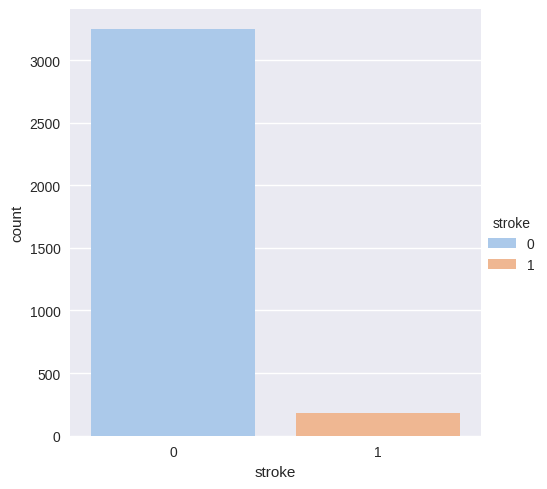

In [115]:
#catplot to see whether the dataset is balanced or not
sns.catplot(x = 'stroke', kind = 'count',hue='stroke', data = stroke_data,palette = 'pastel')

<Axes: xlabel='age', ylabel='bmi'>

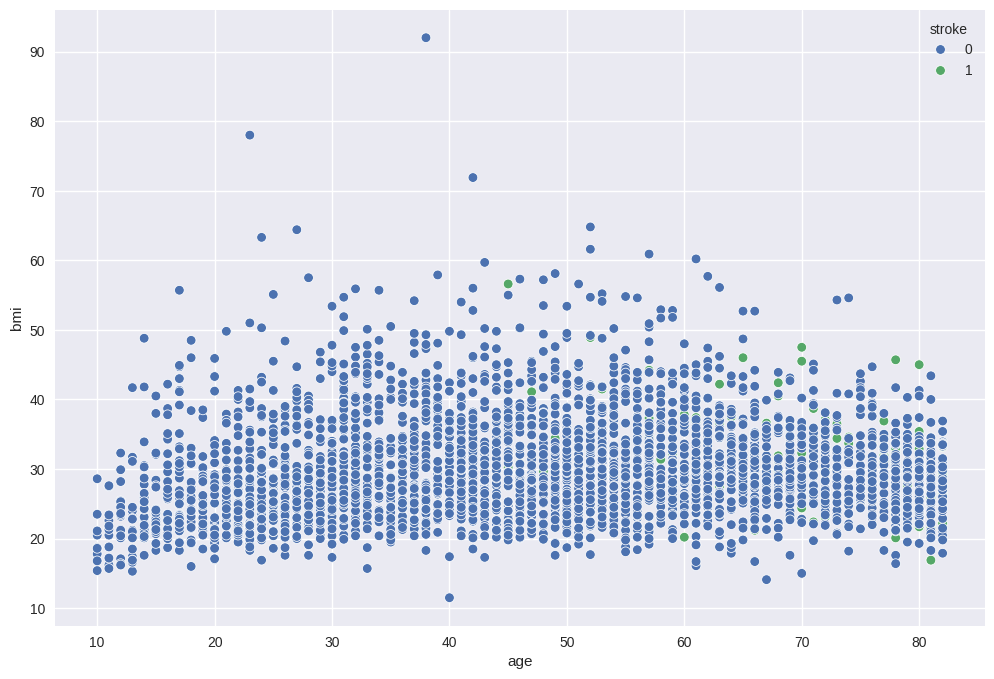

In [116]:
#set figure size
plt.figure(figsize=(12,8))

#scatter plot
sns.scatterplot(x = 'age',y='bmi',hue='stroke',data = stroke_data)

In [117]:
stroke_data['stroke'].value_counts()

0    3245
1     180
Name: stroke, dtype: int64

In [118]:
X = stroke_data.drop(['stroke'],axis=1)
Y = stroke_data['stroke']

In [119]:
X

,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,smoking_status,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children
0,1,67.0,0,1,1,1,228.69,36.6,1,0,0,1,0,0
2,1,80.0,0,1,1,0,105.92,32.5,0,0,0,1,0,0
3,0,49.0,0,0,1,1,171.23,34.4,2,0,0,1,0,0
4,0,79.0,1,0,1,0,174.12,24.0,0,0,0,0,1,0
5,1,81.0,0,0,1,1,186.21,29.0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5100,1,82.0,1,0,1,0,71.97,28.3,0,0,0,0,1,0
5102,0,57.0,0,0,1,0,77.93,21.7,0,0,0,1,0,0
5106,0,81.0,0,0,1,1,125.20,40.0,0,0,0,0,1,0
5107,0,35.0,0,0,1,0,82.99,30.6,0,0,0,0,1,0


In [120]:
Y

0       1
2       1
3       1
4       1
5       1
       ..
5100    0
5102    0
5106    0
5107    0
5108    0
Name: stroke, Length: 3425, dtype: int64

In [121]:
X.shape, Y.shape

((3425, 14), (3425,))

**Select method of handling highly imbalanced dataset**
1. Class Weighted
2. Cross validation
3. Model Selection


*/Upsampling using SMOTE and downsampling may be not suitable/*

#Method 1: Class-Weighted Imbalanced dataset + Model Selection Using Cross Validation + Hyperparameter Tuning

1. Model Selection

In [122]:
#perform train, test split
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.2,random_state=42,shuffle=True)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((2740, 14), (2740,), (685, 14), (685,))

In [123]:
tf.random.set_seed(0)
scaler = StandardScaler()
X=scaler.fit_transform(X)

models = [LogisticRegression(),SVC(),KNeighborsClassifier(),RandomForestClassifier(),GaussianNB()]
def compare_model_cross_validation():
    for model in models:
        cv_score = cross_val_score(model,X,Y,cv=5)
        mean_accuracy = sum(cv_score)/len(cv_score)
        print(f'Cross validation accuracies for the {model} is {cv_score}')
        print(f'Accuracy mean of {model} is {mean_accuracy}')

compare_model_cross_validation()


Cross validation accuracies for the LogisticRegression() is [0.94744526 0.94744526 0.94744526 0.9459854  0.94890511]
Accuracy mean of LogisticRegression() is 0.9474452554744527
Cross validation accuracies for the SVC() is [0.94744526 0.94744526 0.9459854  0.94744526 0.94744526]
Accuracy mean of SVC() is 0.9471532846715329
Cross validation accuracies for the KNeighborsClassifier() is [0.9459854  0.94014599 0.94306569 0.94160584 0.94306569]
Accuracy mean of KNeighborsClassifier() is 0.9427737226277373
Cross validation accuracies for the RandomForestClassifier() is [0.9459854  0.94744526 0.94452555 0.94160584 0.94306569]
Accuracy mean of RandomForestClassifier() is 0.9445255474452555
Cross validation accuracies for the GaussianNB() is [0.06861314 0.08029197 0.08029197 0.07007299 0.08321168]
Accuracy mean of GaussianNB() is 0.07649635036496351


2. Hyperparameter Tuning Using Grid SearchCV

* from the result above, logistic regressoin have highest accuracy mean of 0.9474452554744527
* from previous project, the logistic regression is suitable for handling *imbalanced dataset*

In [124]:
#from the result above, logistic regressoin have highest accuracy mean of 0.9474452554744527
#from previous project, the logistic regression is suitable for handling *imbalanced dataset*
model = LogisticRegression(random_state=0,class_weight='balanced')

specificity_scorer = make_scorer(specificity_score)

parameter= {
'solver': ['newton-cg', 'lbfgs','liblinear'],
'penalty':['l2'],
'C':[0.1,1,10,100],
'max_iter':[100,200,300,400,500,600],
'multi_class':['ovr'],

}

grid_search = GridSearchCV(model,parameter,n_jobs=-1,cv=5,scoring=specificity_scorer,error_score='raise',refit=True)
grid_result = grid_search.fit(X_train, Y_train)

In [125]:
[grid_result.best_score_,grid_result.best_params_]

[0.7315613465229588,
 {'C': 1,
  'max_iter': 100,
  'multi_class': 'ovr',
  'penalty': 'l2',
  'solver': 'newton-cg'}]

In [126]:
train_accuracy = grid_result.score(X_train,Y_train)

print("The Accuracy for Training set is {}".format(train_accuracy*100))

The Accuracy for Training set is 72.88786482334869


3. Confusion Matrix

<Axes: >

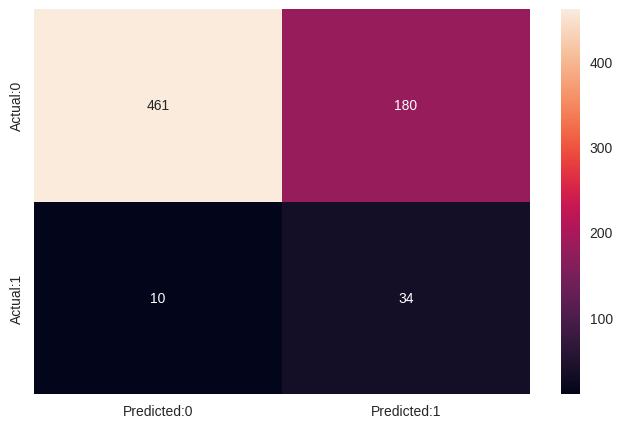

In [127]:
Y_pred = grid_search.predict(X_test)
cm = confusion_matrix(Y_test,Y_pred)
con_matrix = pd.DataFrame(data = cm, columns = ['Predicted:0','Predicted:1'], index = ['Actual:0','Actual:1'])
plt.figure(figsize=(8,5))
sns.heatmap(con_matrix,annot=True,fmt='d')

4. ROC and AUC curve

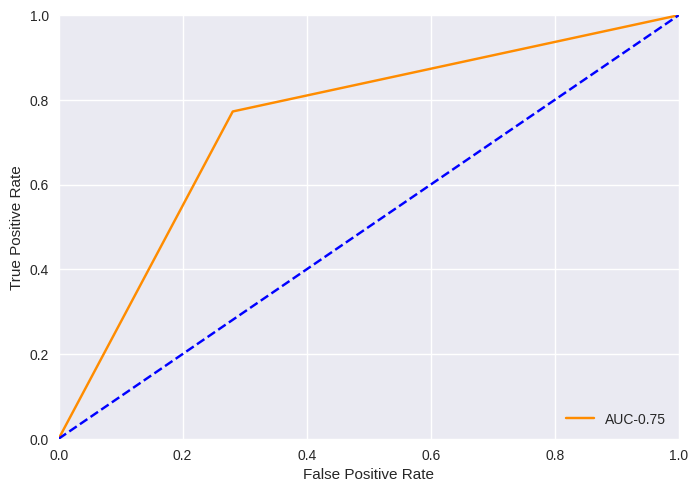

In [128]:
def plot_roc(Y_test,Y_pred):
    fpr,tpr,threshold = roc_curve (Y_test,Y_pred)
    roc_auc=auc(fpr,tpr)
    plt.plot(fpr,tpr,label='AUC-%0.2f'%roc_auc,color='darkorange')
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'b--')
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()

plot_roc(Y_test,Y_pred)

5. Classification Report

In [129]:
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(Y_test, Y_pred)))

print('Micro Precision: {:.2f}'.format(precision_score(Y_test, Y_pred, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(Y_test, Y_pred, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(Y_test, Y_pred, average='micro')))
print('Micro Specificity: {:.2f}\n'.format(specificity_score(Y_test, Y_pred, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(Y_test, Y_pred, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(Y_test, Y_pred, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(Y_test, Y_pred, average='macro')))
print('Macro Specificity: {:.2f}\n'.format(specificity_score(Y_test, Y_pred, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(Y_test, Y_pred, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(Y_test, Y_pred, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(Y_test, Y_pred, average='weighted')))
print('Weighted Specificity: {:.2f}\n'.format(specificity_score(Y_test, Y_pred, average='weighted')))

from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(Y_test, Y_pred, target_names=['Class 1', 'Class 2']))


Accuracy: 0.72

Micro Precision: 0.72
Micro Recall: 0.72
Micro F1-score: 0.72

Micro Specificity: 0.72

Macro Precision: 0.57
Macro Recall: 0.75
Macro F1-score: 0.55

Macro Specificity: 0.75

Weighted Precision: 0.93
Weighted Recall: 0.72
Weighted F1-score: 0.79
Weighted Specificity: 0.77


Classification Report

              precision    recall  f1-score   support

     Class 1       0.98      0.72      0.83       641
     Class 2       0.16      0.77      0.26        44

    accuracy                           0.72       685
   macro avg       0.57      0.75      0.55       685
weighted avg       0.93      0.72      0.79       685



#Method 2: Random Undersampling + Model Selection Using Cross Validation + Hyperparameter Tuning

1. Undersampling

In [44]:
stroke_data['stroke'].value_counts()

0    3245
1     180
Name: stroke, dtype: int64

In [54]:
#perform Undersampling
random_undersampler = RandomUnderSampler(random_state=0)
X_undersampled, Y_undersampled = random_undersampler.fit_resample(X, Y)

In [55]:
Y_undersampled.value_counts()

0    180
1    180
Name: stroke, dtype: int64

2. Train test split

In [59]:
#undersampling
scaler = StandardScaler()
X_train_under, X_test_under, Y_train_under,Y_test_under = train_test_split(X_undersampled, Y_undersampled,test_size=0.2,random_state=42,shuffle=True)
X_train_under = scaler.fit_transform(X_train_under)
X_test_under = scaler.transform(X_test_under)
X_train_under.shape, X_test_under.shape, Y_train_under.shape,Y_test_under.shape

((288, 14), (72, 14), (288,), (72,))

Text(0.5, 1.0, 'Undersampling')

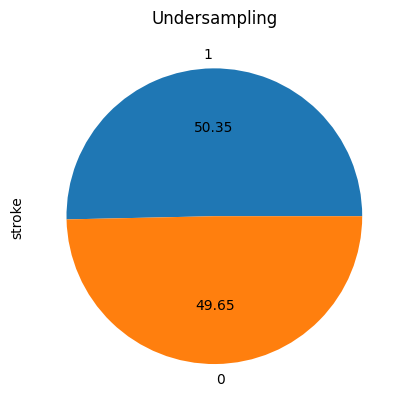

In [61]:
ax = Y_train_under.value_counts().plot.pie(autopct='%.2f')
ax.set_title('Undersampling')

3. Model Selection using Cross Validation

In [65]:
tf.random.set_seed(0)
scaler = StandardScaler()
X_undersampled = scaler.fit_transform(X_undersampled)
models = [LogisticRegression(),SVC(),KNeighborsClassifier(),RandomForestClassifier(),GaussianNB()]
def compare_model_cross_validation():
    for model in models:
        cv_score = cross_val_score(model,X_undersampled,Y_undersampled,cv=5)
        mean_accuracy = sum(cv_score)/len(cv_score)
        print(f'Cross validation accuracies for the {model} is {cv_score}')
        print(f'Accuracy mean of {model} is {mean_accuracy}')

compare_model_cross_validation()

Cross validation accuracies for the LogisticRegression() is [0.69444444 0.79166667 0.76388889 0.76388889 0.70833333]
Accuracy mean of LogisticRegression() is 0.7444444444444445
Cross validation accuracies for the SVC() is [0.625      0.81944444 0.76388889 0.73611111 0.63888889]
Accuracy mean of SVC() is 0.7166666666666666
Cross validation accuracies for the KNeighborsClassifier() is [0.55555556 0.72222222 0.68055556 0.69444444 0.66666667]
Accuracy mean of KNeighborsClassifier() is 0.6638888888888889
Cross validation accuracies for the RandomForestClassifier() is [0.55555556 0.77777778 0.77777778 0.75       0.66666667]
Accuracy mean of RandomForestClassifier() is 0.7055555555555555
Cross validation accuracies for the GaussianNB() is [0.5        0.51388889 0.5        0.51388889 0.56944444]
Accuracy mean of GaussianNB() is 0.5194444444444445


4. Hyperparameter Tuning Using Grid SearchCV





In [71]:
#from the result above, logistic regression have highest accuracy mean of 0.7444444444444445
model = LogisticRegression(random_state=0,class_weight='balanced')

specificity_scorer = make_scorer(specificity_score)

parameter= {
'solver': ['newton-cg', 'lbfgs','liblinear'],
'penalty':['l2'],
'C':[0.1,1,10,100],
'max_iter':[100,200,300,400,500,600],
'multi_class':['ovr'],

}

grid_search = GridSearchCV(model,parameter,n_jobs=-1,cv=5,scoring=specificity_scorer,error_score='raise',refit=True)
grid_result = grid_search.fit(X_train_under, Y_train_under)

In [72]:
[grid_result.best_score_,grid_result.best_params_]

[0.7137931034482758,
 {'C': 10,
  'max_iter': 100,
  'multi_class': 'ovr',
  'penalty': 'l2',
  'solver': 'newton-cg'}]

In [73]:
train_accuracy = grid_result.score(X_train_under,Y_train_under)

print("The Accuracy for Training set is {}".format(train_accuracy*100))

The Accuracy for Training set is 73.42657342657343


5. Confusion Matrix

<Axes: >

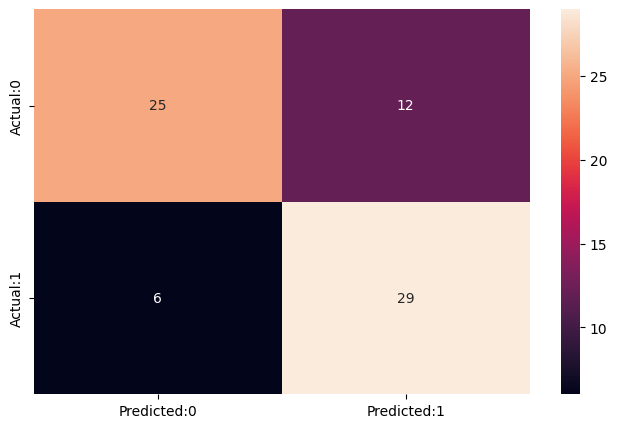

In [74]:
Y_pred_under = grid_search.predict(X_test_under)
cm = confusion_matrix(Y_test_under,Y_pred_under)
con_matrix = pd.DataFrame(data = cm, columns = ['Predicted:0','Predicted:1'], index = ['Actual:0','Actual:1'])
plt.figure(figsize=(8,5))
sns.heatmap(con_matrix,annot=True,fmt='d')

6. ROC and AUC curve

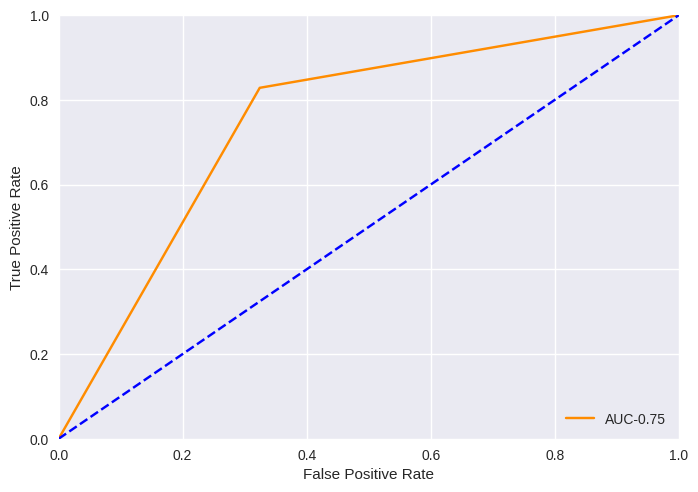

In [82]:
def plot_roc(Y_test_under,Y_pred_under):
    fpr,tpr,threshold = roc_curve (Y_test_under,Y_pred_under)
    roc_auc=auc(fpr,tpr)
    plt.plot(fpr,tpr,label='AUC-%0.2f'%roc_auc,color='darkorange')
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'b--')
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()

plot_roc(Y_test_under,Y_pred_under)

7. Classification Report

In [91]:
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(Y_test_under, Y_pred_under)))

print('Micro Precision: {:.2f}'.format(precision_score(Y_test_under, Y_pred_under, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(Y_test_under, Y_pred_under, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(Y_test_under, Y_pred_under, average='micro')))
print('Micro Specificity: {:.2f}\n'.format(specificity_score(Y_test_under, Y_pred_under, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(Y_test_under, Y_pred_under, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(Y_test_under, Y_pred_under, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(Y_test_under, Y_pred_under, average='macro')))
print('Macro Specificity: {:.2f}\n'.format(specificity_score(Y_test_under, Y_pred_under, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(Y_test_under, Y_pred_under, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(Y_test_under, Y_pred_under, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(Y_test_under, Y_pred_under, average='weighted')))
print('Weighted Specificity: {:.2f}\n'.format(specificity_score(Y_test_under, Y_pred_under, average='weighted')))

from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(Y_test_under, Y_pred_under, target_names=['Class 0', 'Class 1']))


Accuracy: 0.75

Micro Precision: 0.75
Micro Recall: 0.75
Micro F1-score: 0.75

Micro Specificity: 0.75

Macro Precision: 0.76
Macro Recall: 0.75
Macro F1-score: 0.75

Macro Specificity: 0.75

Weighted Precision: 0.76
Weighted Recall: 0.75
Weighted F1-score: 0.75
Weighted Specificity: 0.75


Classification Report

              precision    recall  f1-score   support

     Class 0       0.81      0.68      0.74        37
     Class 1       0.71      0.83      0.76        35

    accuracy                           0.75        72
   macro avg       0.76      0.75      0.75        72
weighted avg       0.76      0.75      0.75        72



#Method 3: SMOTE Upsampling + Model Selection Using Cross Validation + Hyperparameter Tuning

1. Upsampling

In [56]:
#perform upsampling
smote = SMOTE()
X_upsampled, Y_upsampled = smote.fit_resample(X,Y)

In [57]:
Y_upsampled.value_counts()

1    3245
0    3245
Name: stroke, dtype: int64

2. Train test split

In [62]:
#upsampling
scaler = StandardScaler()
X_train_up, X_test_up, Y_train_up,Y_test_up = train_test_split(X_upsampled, Y_upsampled,test_size=0.2,random_state=42,shuffle=True)
X_train_up = scaler.fit_transform(X_train_up)
X_test_up = scaler.transform(X_test_up)
X_train_up.shape, X_test_up.shape, Y_train_up.shape,Y_test_up.shape

((5192, 14), (1298, 14), (5192,), (1298,))

Text(0.5, 1.0, 'Upsampling')

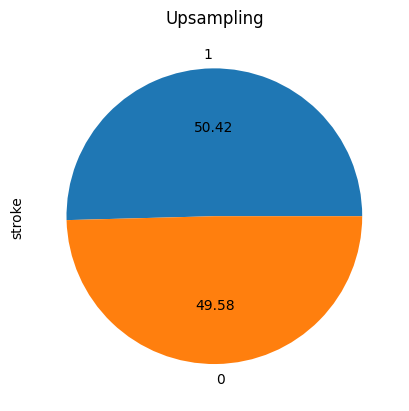

In [63]:
ax = Y_train_up.value_counts().plot.pie(autopct='%.2f')
ax.set_title('Upsampling')

3. Model Selection using Cross Validation

In [66]:
tf.random.set_seed(0)
scaler = StandardScaler()
X_upsampled = scaler.fit_transform(X_upsampled)
models = [LogisticRegression(),SVC(),KNeighborsClassifier(),RandomForestClassifier(),GaussianNB()]
def compare_model_cross_validation():
    for model in models:
        cv_score = cross_val_score(model,X_upsampled,Y_upsampled,cv=5)
        mean_accuracy = sum(cv_score)/len(cv_score)
        print(f'Cross validation accuracies for the {model} is {cv_score}')
        print(f'Accuracy mean of {model} is {mean_accuracy}')

compare_model_cross_validation()

Cross validation accuracies for the LogisticRegression() is [0.76579353 0.85901387 0.84976888 0.85670262 0.85208012]
Accuracy mean of LogisticRegression() is 0.8366718027734977
Cross validation accuracies for the SVC() is [0.81278891 0.88366718 0.87673344 0.89291217 0.87827427]
Accuracy mean of SVC() is 0.8688751926040063
Cross validation accuracies for the KNeighborsClassifier() is [0.85053929 0.903698   0.90986133 0.92372881 0.91371341]
Accuracy mean of KNeighborsClassifier() is 0.9003081664098612
Cross validation accuracies for the RandomForestClassifier() is [0.89368259 0.97149461 0.96918336 0.96918336 0.96224961]
Accuracy mean of RandomForestClassifier() is 0.9531587057010787
Cross validation accuracies for the GaussianNB() is [0.56163328 0.52003082 0.52234206 0.52234206 0.52080123]
Accuracy mean of GaussianNB() is 0.5294298921417566


4. Hyperparameter Tuning Using Grid SearchCV


In [67]:
#as Random Forest have highest accuracy mean of 0.9531587057010787
model = RandomForestClassifier(random_state = 0)

specificity_scorer = make_scorer(specificity_score)

parameter = {
'n_estimators' : [50,100,150],
'max_depth' : [5,10,15,None],
'min_samples_split': [3,5],
'min_samples_leaf': [1,2,3,4],
'max_features': ['log2']
}


grid_search = GridSearchCV(model,parameter,n_jobs=-1,cv=5,scoring=specificity_scorer,error_score='raise',refit=True)
grid_result = grid_search.fit(X_train_up, Y_train_up)

In [68]:
[grid_result.best_score_,grid_result.best_params_]

[0.9428854217823279,
 {'max_depth': None,
  'max_features': 'log2',
  'min_samples_leaf': 1,
  'min_samples_split': 5,
  'n_estimators': 100}]

In [69]:
train_accuracy = grid_result.score(X_train_up,Y_train_up)

print("The Accuracy for Training set is {}".format(train_accuracy*100))

The Accuracy for Training set is 99.76689976689977


5. Confusion Matrix

<Axes: >

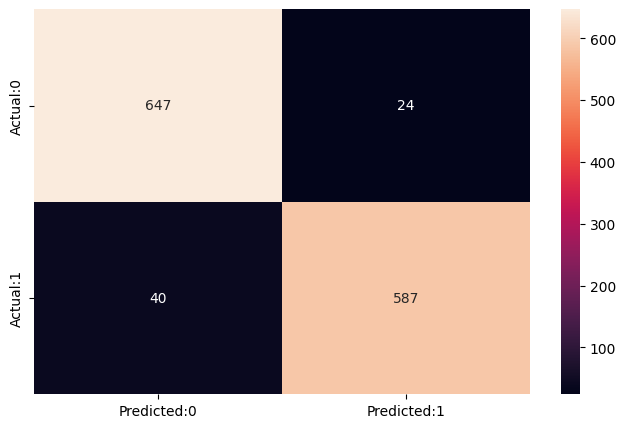

In [70]:
Y_pred_up = grid_search.predict(X_test_up)
cm = confusion_matrix(Y_test_up,Y_pred_up)
con_matrix = pd.DataFrame(data = cm, columns = ['Predicted:0','Predicted:1'], index = ['Actual:0','Actual:1'])
plt.figure(figsize=(8,5))
sns.heatmap(con_matrix,annot=True,fmt='d')

6. ROC and AUC curve

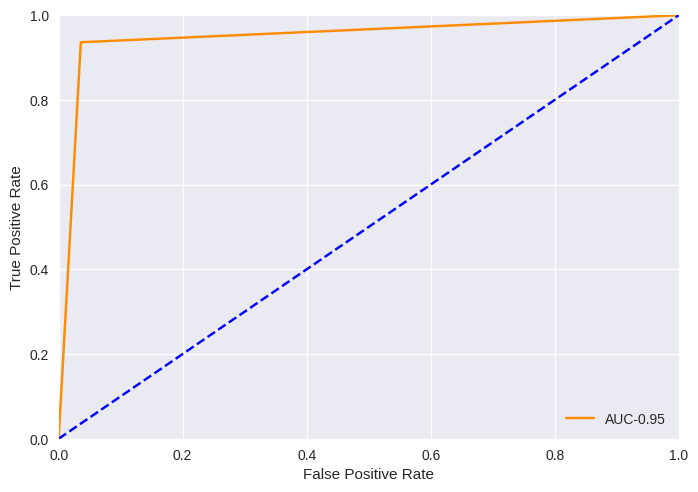

In [80]:
def plot_roc(Y_test_up,Y_pred_up):
    fpr,tpr,threshold = roc_curve (Y_test_up,Y_pred_up)
    roc_auc=auc(fpr,tpr)
    plt.plot(fpr,tpr,label='AUC-%0.2f'%roc_auc,color='darkorange')
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'b--')
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()

plot_roc(Y_test_up,Y_pred_up)

7. Classification Report

In [92]:
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(Y_test_up, Y_pred_up)))

print('Micro Precision: {:.2f}'.format(precision_score(Y_test_up, Y_pred_up, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(Y_test_up, Y_pred_up, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(Y_test_up, Y_pred_up, average='micro')))
print('Micro Specificity: {:.2f}\n'.format(specificity_score(Y_test_up, Y_pred_up, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(Y_test_up, Y_pred_up, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(Y_test_up, Y_pred_up, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(Y_test_up, Y_pred_up, average='macro')))
print('Macro Specificity: {:.2f}\n'.format(specificity_score(Y_test_up, Y_pred_up, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(Y_test_up, Y_pred_up, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(Y_test_up, Y_pred_up, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(Y_test_up, Y_pred_up, average='weighted')))
print('Weighted Specificity: {:.2f}\n'.format(specificity_score(Y_test_up, Y_pred_up, average='weighted')))

from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(Y_test_up, Y_pred_up, target_names=['Class 0', 'Class 1']))


Accuracy: 0.95

Micro Precision: 0.95
Micro Recall: 0.95
Micro F1-score: 0.95

Micro Specificity: 0.95

Macro Precision: 0.95
Macro Recall: 0.95
Macro F1-score: 0.95

Macro Specificity: 0.95

Weighted Precision: 0.95
Weighted Recall: 0.95
Weighted F1-score: 0.95
Weighted Specificity: 0.95


Classification Report

              precision    recall  f1-score   support

     Class 0       0.94      0.96      0.95       671
     Class 1       0.96      0.94      0.95       627

    accuracy                           0.95      1298
   macro avg       0.95      0.95      0.95      1298
weighted avg       0.95      0.95      0.95      1298



#Conclusion

From the confusion matrix, roc and auc curver and the classification report, model in method 3 is the most suitable model in this project.

However, there maybe a risk problem in overfitting due to the upsampling(SMOTE).Future improvement maybe perform ensemble method model selection.